## Data Visualisation 

Course Data Visualiation by Prof. Konrad Föstner 

Finn Heydemann, Master, Digital Science TH Köln 

Winter Semester 2022/23 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import random
import os 
import datetime
from itertools import cycle 

In [2]:
col_names = pd.read_csv("archive/columns_description.csv")["columns_en"]

### Raw Data is not included in github repository as it is too large. 
As I only work with minimzed data (6 weather stations only) you will not need it.  <br>
If for some reasons you do need the raw data, please download them yourself from: <br>
https://www.kaggle.com/datasets/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region

In [3]:
import os 
from shapely.geometry import Polygon, Point
import geopandas as gpd


shapefile = "ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
gdf = gpd.read_file(shapefile)[['ADMIN', 'ADM0_A3', 'geometry']]
gdf.columns = ['country', 'country_code', 'geometry']
gdf_brazil = gdf[gdf["country"]=="Brazil"]
brazil_shape = gdf_brazil.geometry

In [4]:
def read_single_w_station(filename: str, amount:int=1):
    station_gen = get_df_rows(filename)
    for _ in range(amount): 
        rows_to_exclude = next(station_gen)
        df = pd.read_csv("archive/{}.csv".format(filename),
                         skiprows=rows_to_exclude, header=None)
        df.drop(0, axis=1, inplace=True)
        df.columns = col_names
        df["timestamp"] = pd.to_datetime((df["date"] + "-" + df["hour"]), format="%Y-%m-%d-%H:%M")
        df.drop(["date", "hour"], axis=1, inplace=True)
        df.set_index("timestamp", inplace=True)
        df.sort_index(inplace=True)
        df.replace(-9999, np.nan, inplace=True)
        save_df("read_data", filename + "_" + df.iloc[0]["station_code"], df)
        
def point_inside(row: pd.Series): 
    return brazil_shape.contains(Point(row["longitude"], row["latitude"])) * 1


def get_df_rows(filename: str):
    
    # include point with max and min longitude and latitude of every direction 
    # if weather station is located within the the brazilian mainland and 
    # not on some remote island 
    long_lat = pd.read_csv("archive/{}.csv".format(filename), 
                           usecols=["latitude", "longitude", "station_code"])
    
    long_lat["inside"] = long_lat.drop_duplicates(subset="station_code").apply(point_inside, axis=1)
    stations_to_exclude = long_lat[np.logical_and(np.logical_not(np.isnan(long_lat["inside"])), 
                                                  long_lat["inside"] == 0)]["station_code"]
    long_lat = long_lat[long_lat["station_code"].isin(np.setdiff1d(long_lat["station_code"], stations_to_exclude))]
            
    
    outter_stations = np.array([long_lat["station_code"].iloc[long_lat["longitude"].argmax()], 
                                long_lat["station_code"].iloc[long_lat["longitude"].argmin()],
                                long_lat["station_code"].iloc[long_lat["latitude"].argmax()], 
                                long_lat["station_code"].iloc[long_lat["latitude"].argmin()]])
    remaining_stations = np.setdiff1d(long_lat["station_code"].unique(), outter_stations)
    np.random.seed(5)
    np.random.shuffle(remaining_stations)
    ids = np.hstack((outter_stations, 
                     remaining_stations))
    for st_id in ids:
        rows_to_keep = set(np.where(pd.read_csv("archive/{}.csv".format(filename),
                                            usecols=["station_code"]) == st_id)[0] + 1)
        num_lines = sum(1 for _ in open("archive/{}.csv".format(filename), encoding="utf-8"))
        yield set(range(num_lines)) - rows_to_keep


def save_df(path, filename, df):
    if not os.path.exists(path): 
        os.mkdir(path)
    path = os.path.join(path, filename + ".csv")
    print(path)
    df.to_csv(path, columns=["total precipitation (mm)",
                             "max. temperature in the previous hour (°c)", 
                             "station_code", 
                             "latitude", 
                             "longitude"])
    

In [5]:

# only needed when working with raw data, else use functions below 
# takes a while as data is huge 
# activate by setting False to True
switch_run_splitting = False
if switch_run_splitting: 
    for direction in ["central_west", "south", "north", "northeast", "southeast"]: 
        print(direction)
        read_single_w_station(direction, 8)

In [6]:
def read_local(filename: str):
    df = pd.read_csv("read_data/" + file)
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df.set_index("timestamp", inplace=True)
    return df

walker = next(os.walk("read_data"))
data = {key.rsplit("_", 1)[0]: [] for key in walker[-1]}
for file in walker[-1]:
    print(file)
    data[file.rsplit("_", 1)[0]] += [read_local("read_data/" + file)]

data.keys()
 

central_west_A017.csv
northeast_A427.csv
northeast_A320.csv
central_west_A910.csv
southeast_A746.csv
north_A230.csv
northeast_A355.csv
northeast_A219.csv
north_A233.csv
south_A850.csv
south_A809.csv
central_west_A922.csv
south_A856.csv
southeast_A567.csv
south_A899.csv
central_west_A033.csv
north_A135.csv
south_A838.csv
northeast_A205.csv
southeast_A762.csv
southeast_A733.csv
north_S104.csv
central_west_A751.csv
central_west_A036.csv
southeast_A526.csv
central_west_A935.csv
north_A040.csv
north_A242.csv
north_A128.csv
south_A847.csv
southeast_A548.csv
north_A137.csv
northeast_A405.csv
southeast_A553.csv
northeast_A340.csv
southeast_A616.csv
south_A842.csv
south_A830.csv
central_west_A022.csv
northeast_A352.csv


dict_keys(['central_west', 'northeast', 'southeast', 'north', 'south'])

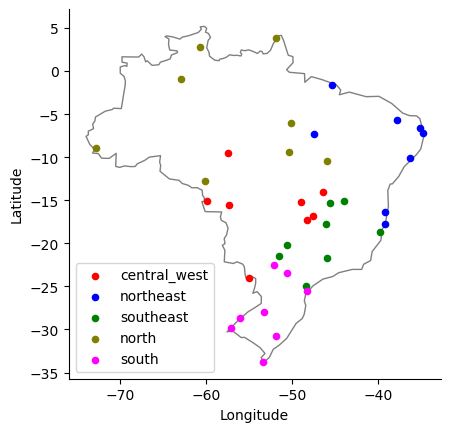

In [7]:
from itertools import cycle

colors = {"central_west": "red", 
          "northeast": "blue", 
          "southeast": "green", 
          "south": "magenta", 
          "north": "olive"}

def plot_coordinates(data, *keys, annotate=False):
    ax = gdf[gdf["country"]=="Brazil"].plot(color="white", edgecolor="gray")

    for key, values in data.items(): 
        df = {"name": [], "Latitude": [], "Longitude": []}
        for val in values:
            name = val.iloc[0].station_code
            if name in keys or keys == ():
                latitude = val.iloc[0].latitude
                longitude = val.iloc[0].longitude
                df["name"].append(key + name)
                df["Latitude"].append(latitude)
                df["Longitude"].append(longitude)
                if annotate: 
                    plt.annotate(name, (longitude + 1, latitude))
        df = pd.DataFrame(df)
        if not df.empty:
            gxdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
            gxdf.plot(ax=ax, color=colors[key], label=key, markersize=20)
    ax.legend(loc="lower left") 
    ax.set_ylabel("Latitude")
    ax.set_xlabel("Longitude")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
            
            
plot_coordinates(data)

In [8]:
from bokeh.plotting import figure, ColumnDataSource, output_notebook
from bokeh.io import show
from bokeh.models import HoverTool

In [9]:
def interactive_weather_stations(data, *station_codes): 
    exterior_coords = {"x": brazil_shape.iloc[0].exterior.xy[0], 
                       "y": brazil_shape.iloc[0].exterior.xy[1]}
    
    exterior_source = ColumnDataSource(exterior_coords)
    p = figure(title="Weather Stations")
    p.line("x", "y", source=exterior_source, color="blue", line_color="blue")
    
    plot_data = pd.DataFrame(np.array(*[[np.hstack((i.iloc[0][["station_code",
                                            "latitude", 
                                            "longitude"]].to_numpy(), 
                                            np.nanmean(i[["max. temperature in the previous hour (°c)", 
                                              "total precipitation (mm)"]].to_numpy(), axis=0), 
                                            x, colors[x])) 
                                 for x, y in data.items() for i in y]]), 
                      columns=["station_code", "latitude", "longitude", 
                               "temperature", "precipitation", "direction", "color"])
    if station_codes != (): 
        plot_data = plot_data.loc[plot_data["station_code"].isin(station_codes)]
        
    name_source = ColumnDataSource(plot_data)
    
    circles = p.circle("longitude", "latitude", 
                       source=name_source, 
                       radius=0.5, 
                       fill_color="color", 
                       fill_alpha=0.5, line_color="black")
    p.add_tools(HoverTool(tooltips=[("direction", "@direction"), 
                                    ("station_code", "@station_code"), 
                                    ("avg. temp", "@temperature"), 
                                    ("avg. precipitation / h", "@precipitation")], 
                          renderers=[circles]))

    output_notebook()
    show(p)

interactive_weather_stations(data)

Loading BokehJS ...

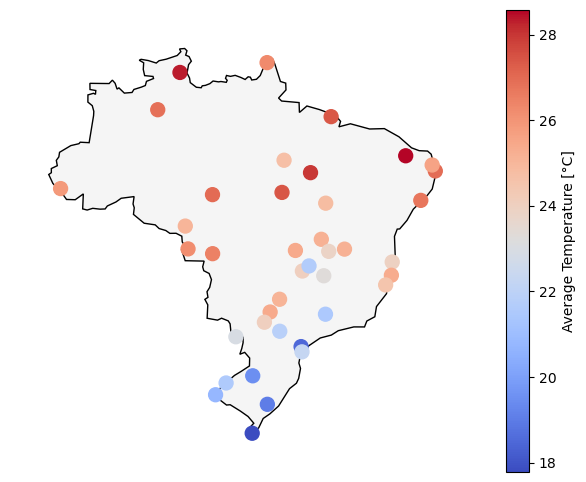

In [10]:
import geoplot as gplt 
import geoplot.crs as gcrs

def location_plot(data: dict, weather_type: str="temperature"): 
    
    geo_plot_data = gpd.GeoDataFrame([(np.nanmean(df["max. temperature in the previous hour (°c)"]),
                                       np.nanmean(df["total precipitation (mm)"]), 
                                       Point(df.iloc[0].longitude,
                                             df.iloc[0].latitude)) for key, value in data.items() for df in value], 
                    columns=["average temp", "average precipation", "geometry"])
    if weather_type == "temperature": 
        ax = gplt.pointplot(geo_plot_data, hue="average temp", legend=True, cmap="coolwarm", s=10, 
                            legend_kwargs={"label": "Average Temperature [°C]"})

        gplt.polyplot(brazil_shape, facecolor="whitesmoke", ax=ax)
    elif weather_type == "precipation": 
        ax = gplt.pointplot(geo_plot_data, hue="average precipation", legend=True, s=10,
                            legend_kwargs={"label": "Average Precipation [mm/h]"})

        gplt.polyplot(brazil_shape, facecolor="whitesmoke", ax=ax)

    

location_plot(data)

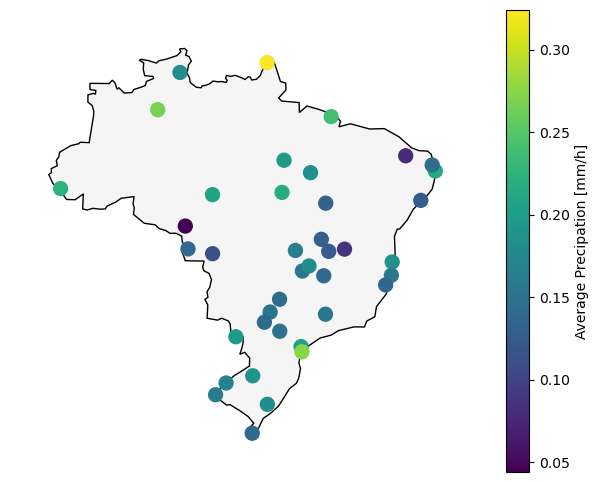

In [11]:
location_plot(data, "precipation")

In [12]:
data["central_west"][0]

,total precipitation (mm),max. temperature in the previous hour (°c),station_code,latitude,longitude
timestamp,,,,,
2007-04-18 00:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 01:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 02:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 03:00:00,NaN,NaN,A017,-14.089167,-46.366389
2007-04-18 04:00:00,NaN,NaN,A017,-14.089167,-46.366389
...,...,...,...,...,...
2021-04-30 19:00:00,0.0,27.5,A017,-14.089167,-46.366389
2021-04-30 20:00:00,0.0,27.1,A017,-14.089167,-46.366389
2021-04-30 21:00:00,0.0,25.8,A017,-14.089167,-46.366389


In [77]:
from scipy.ndimage import uniform_filter1d

def plot_temp(data, *keys, start_date, end_date, colors=None, **kwargs): 
    """
    This function plots temperature line plots over time. Please insert the data, the keys you want to plot
    as well as the start and end dates
    if you want to see the raw data set raw=True; if you want a moving average set moving_mean=True with a 
    mov_mean_period = e.g. (20, "day"); and specify wheather you want to see the (annotated) extrems of every year
    """
    if colors is None: 
        colors = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"])
    fig, ax = plt.subplots()
    for key, index in keys:
        plot_data = data[key][index]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date),
                             "max. temperature in the previous hour (°c)"] 
        plot_data.fillna(np.nanmedian(plot_data.to_numpy()), inplace=True)
        if kwargs.get("raw"):
            plt.plot(plot_data, lw=0.05, 
                     label="raw temp data {key} {code}".format(key=key, 
                                                               code=data[key][index].iloc[0]["station_code"]), 
                    zorder=1, 
                    color=next(colors))
        if kwargs.get("moving_mean"):
            filter_period, period_type = kwargs.get("mov_mean_period")
            if period_type == "month": 
                filter_period *= 30 * 24 
            elif period_type == "day": 
                filter_period *= 24
            plot_data_filtered = pd.DataFrame({"filt_data": uniform_filter1d(plot_data.to_numpy(), 
                                                       filter_period)}, index=plot_data.index)
            plt.plot(plot_data_filtered,
                     label="moving_ave {0} {1} {key} {code}".format(*kwargs.get("mov_mean_period"), 
                                                                   key=key, 
                                                                   code=data[key][index].iloc[0]["station_code"]), 
                    zorder=2, 
                    color=next(colors))
            
            if kwargs.get("mark_extrem"):
                # grouping by year isn't trival
                # low and high yearly temperatures are likely to be measured in two consecutive months 
                # thats why I split in April where neighter extreme high nor extreme low temperatures are expected 
                max_temp = plot_data_filtered.loc[plot_data_filtered.groupby(
                    pd.Grouper(freq="A-APR"))["filt_data"].idxmax()]
                
                min_temp = plot_data_filtered.loc[plot_data_filtered.groupby(
                    pd.Grouper(freq="A-APR"))["filt_data"].idxmin()]
                extrems = pd.concat((max_temp, min_temp))
                
                plt.scatter(extrems.index, 
                            extrems["filt_data"],
                            s=50, c=extrems["filt_data"], cmap="coolwarm", zorder=3)
                if kwargs.get("annotate"):
                    for index, val in extrems.iterrows():
                        plt.annotate("{:.1f}".format(float(val)), (index, float(val)), fontsize=8)
                
    ax.set_ylabel("Temperature [°C]")
    ax.set_xlabel("Date")
    if kwargs.get("grid"):
        ax.grid()
    plt.xticks(rotation=20)
    plt.legend(fontsize="small") #, bbox_to_anchor=(0.3, 1))



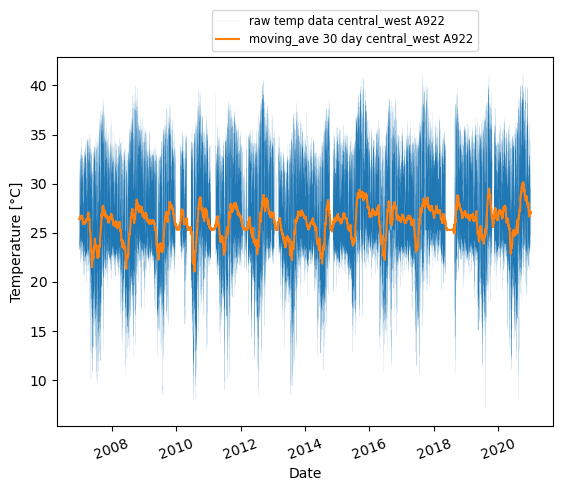

In [69]:
plot_temp(data, 
          ("central_west", 2), 
          start_date=(2007, 1, 1), 
          end_date=(2020, 12, 31), 
          moving_mean=True, 
          raw=True,
          mark_extrem=False, 
          mov_mean_period=(30, "day"))

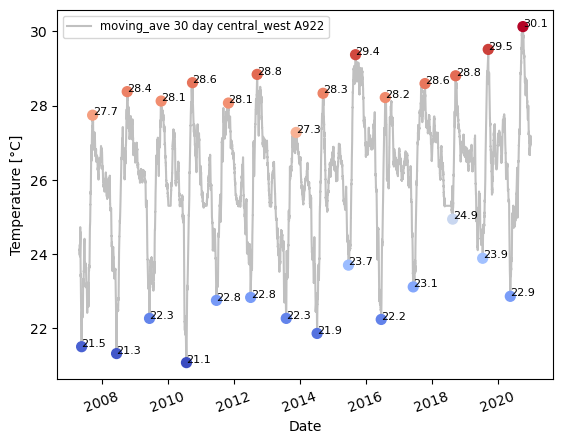

In [34]:
plot_temp(data, 
          ("central_west", 2), 
          start_date=(2007, 5, 1), 
          end_date=(2020, 12, 31), 
          colors=cycle(["silver"]),
          moving_mean=True, 
          raw=False,
          mark_extrem=True,
          annotate=True,
          mov_mean_period=(30, "day"))

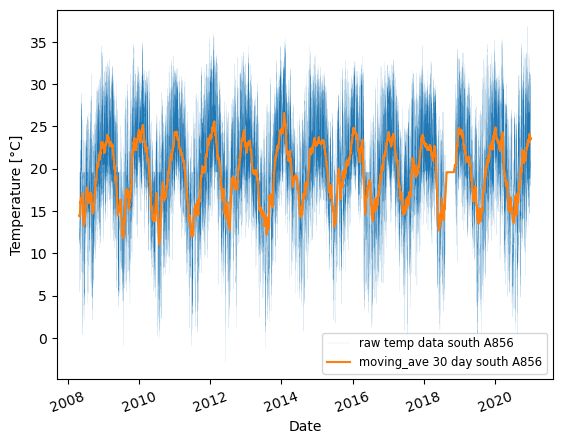

In [78]:
plot_temp(data, 
          ("south", 2), 
          start_date=(2008, 5, 1), 
          end_date=(2020, 12, 31), 
          moving_mean=True, 
          raw=True,
          mark_extrem=False, 
          mov_mean_period=(30, "day"))

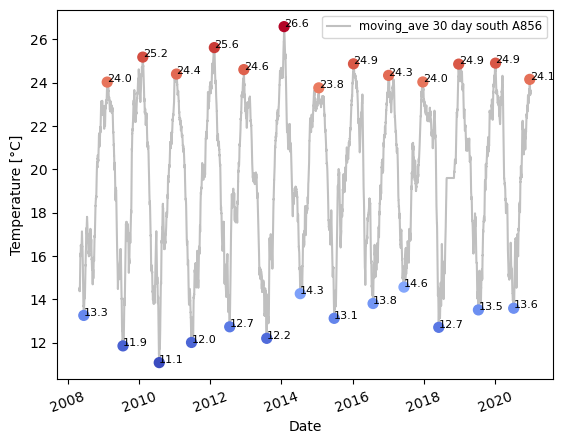

In [35]:
plot_temp(data, 
          ("south", 2), 
          start_date=(2008, 5, 1), 
          end_date=(2020, 12, 31), 
          colors=cycle(["silver"]), 
          moving_mean=True, 
          raw=False,
          mark_extrem=True,
          annotate=True,
          mov_mean_period=(30, "day"))

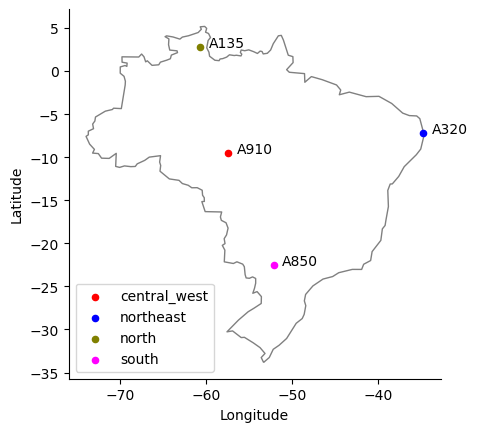

In [17]:
plot_coordinates(data, "A910", "A850", "A320", "A135", annotate=True)

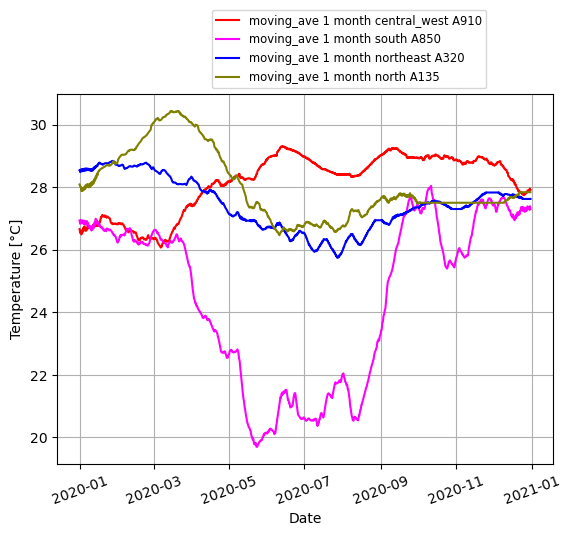

In [70]:
plot_temp(data, 
          ("central_west", 1), 
          ("south", 0),
          ("northeast", 1), 
          ("north", 2),
          start_date=(2020, 1, 1), 
          end_date=(2020, 12, 31), 
          colors=cycle([colors["central_west"], colors["south"], colors["northeast"], colors["north"]]),
          moving_mean=True, 
          mov_mean_period=(1, "month"), 
          grid=True)

In [19]:
def boxplots(data, *keys, start_date, end_date, colors=None, seperator="Q", apart=0.25, **kwargs):
    """
    Makes a boxplot out of given data, start and end date can be defined as can be seperator which specifies 
    how data is seperated 
    
    # todo: If data is not present in one weather station, make sure plots are still on right quartil, month etc. 
    """
    if colors is None: 
        colors = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"])
    w_stations = {}
    station_code = []
    for key, index in keys: 
        plot_data = data[key][index]
        station_code.append(plot_data.iloc[0]["station_code"])
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                          "max. temperature in the previous hour (°c)"] 
        plot_data = plot_data.groupby(pd.Grouper(freq=seperator))
        d_single = {}
        for period in plot_data.groups.keys(): 
            x = plot_data.get_group(period).to_numpy()
            x[np.argwhere(np.isnan(x))] = np.nanmedian(x)
            d_single[period] = x
            
        w_stations[key + str(index)] = d_single
    fig, ax = plt.subplots()
    elements = []
    for shift, (key, index) in zip(np.linspace(-apart, 
                                               apart, 
                                               len(keys)) if len(keys) > 1 else [0], keys):
        elements.append(ax.boxplot(w_stations[key + str(index)].values(), 0, "", 
                                   positions=[shift + l for l in range(len(w_stations[key + str(index)]))], 
                                   patch_artist=True, 
                                   boxprops={"facecolor":next(colors)}, 
                                   medianprops={"color": "black"}, 
                                   **kwargs
                                  ))
        
        plt.xticks(range(len(w_stations[key + str(index)])), 
                   [seperator + str(j) for j in range(1, len(w_stations[key + str(index)])+1)], 
                   rotation=20) 
    ax.set_ylabel("Temperature [°C]")
    ax.legend([element["boxes"][0] for element in elements], 
              [key[:-1] + " " + code for key, code in zip(w_stations.keys(), station_code)])

    

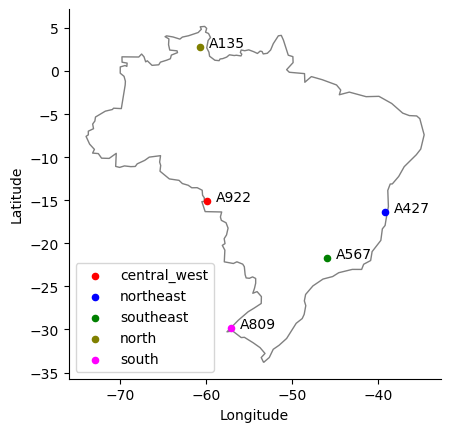

In [20]:
plot_coordinates(data, "A135", "A922", "A427", "A567", "A809", annotate=True)

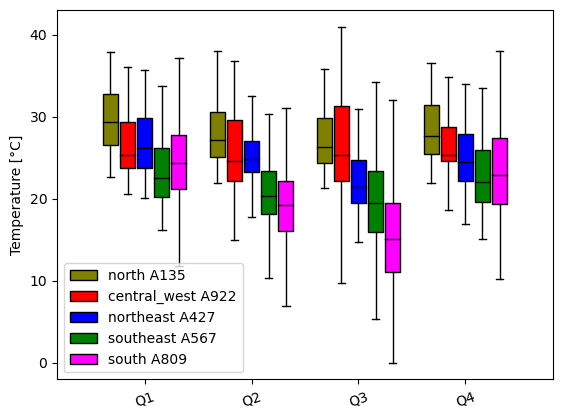

In [21]:
boxplots(data, 
         ("north", 2),  
         ("central_west", 2),
         ("northeast", 0),
         ("southeast", 1),
         ("south", 1),
         start_date=(2019, 1, 1), 
         end_date=(2019, 12, 31), 
         colors=cycle([colors["north"], colors["central_west"], colors["northeast"], 
                      colors["southeast"], colors["south"]]),
         apart=0.32,
         seperator="Q", 
         widths=0.14)

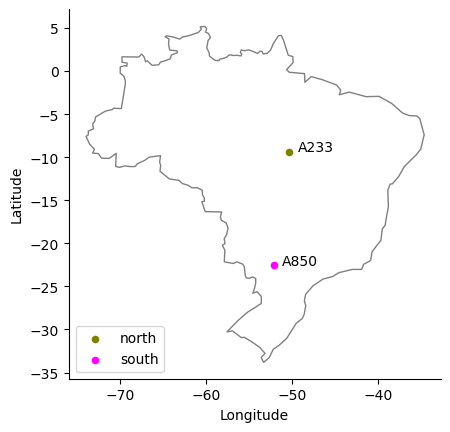

In [22]:
plot_coordinates(data, "A850", "A233", annotate=True)

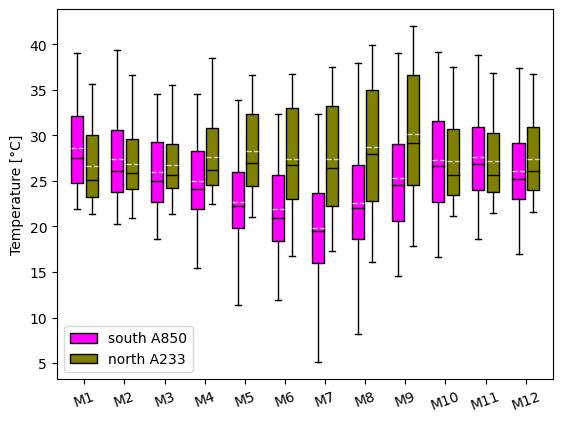

In [23]:
boxplots(data, 
         ("south", 0), 
         ("north", 1),
         start_date=(2019, 1, 1), 
         end_date=(2019, 12, 31), 
         colors = cycle([colors["south"], colors["north"]]),
         apart=0.18,
         seperator="M", 
         meanline=True, 
         showmeans=True,
         meanprops={"color": "lightgray", "linestyle": "--"}, 
         widths=0.3)

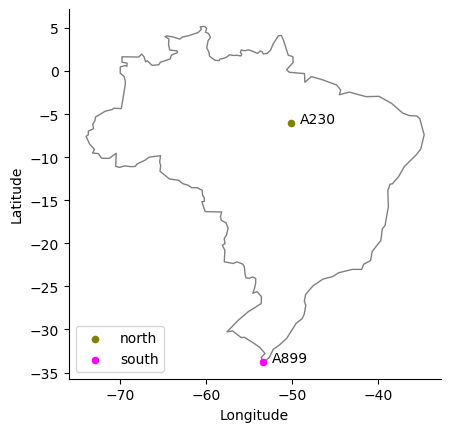

In [75]:
plot_coordinates(data, "A899", "A230", annotate=True)

In [74]:
interactive_weather_stations(data, "A899", "A230")

Loading BokehJS ...

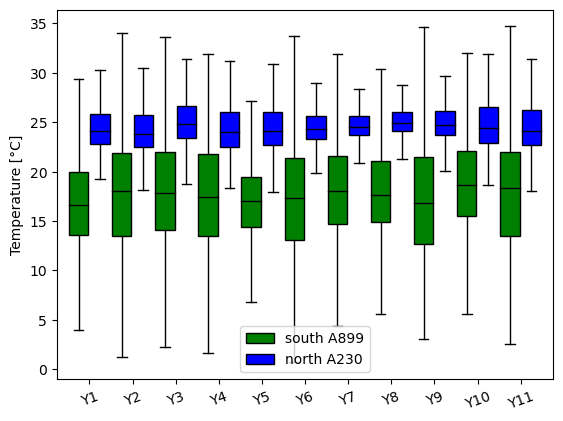

In [72]:
boxplots(data, 
         ("south", 3),
         ("north", 0),
         start_date=(2008, 1, 1), 
         end_date=(2018, 12, 31),
         colors = cycle([colors["southeast"], colors["northeast"]]),
         seperator="Y",
         widths=0.45
        )

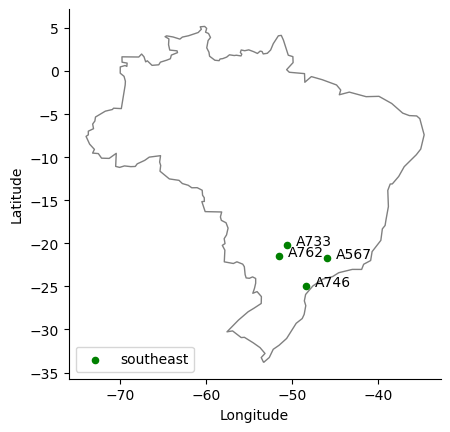

In [27]:
plot_coordinates(data, "A746", "A567", "A762", "A733", annotate=True)

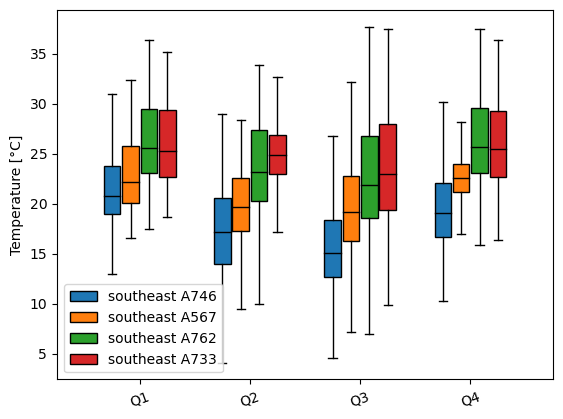

In [28]:
boxplots(data, 
         ("southeast", 0),
         ("southeast", 1), 
         ("southeast", 2), 
         ("southeast", 3),
         start_date=(2018, 1, 1),
         end_date=(2018, 12, 31),
         seperator="Q", widths=0.15)

In [29]:
interactive_weather_stations(data, "A922", "A809", "A567", "A135", "A320")

Loading BokehJS ...

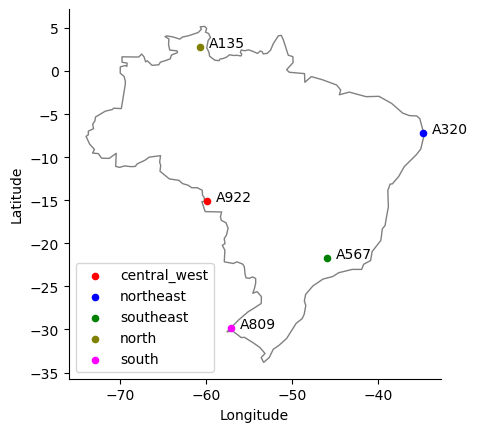

In [30]:
plot_coordinates(data, "A922", "A809", "A567", "A135", "A320", annotate=True)

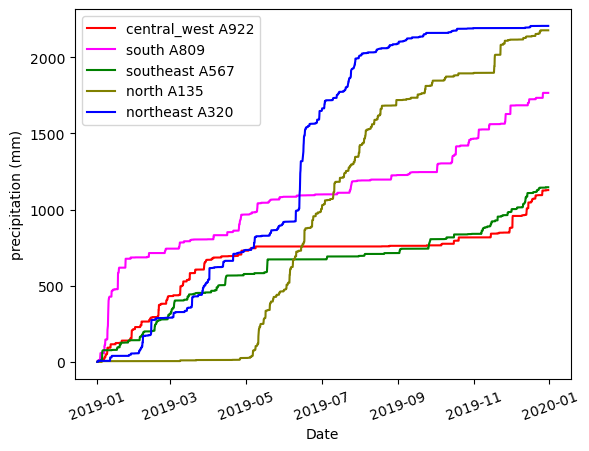

In [31]:
def cumulative_percipitation_plot(data, *keys, start_date, end_date, colors=None):
    fig, ax = plt.subplots()
    if colors is None: 
        colors = cycle(["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink"])
    for key, index in keys: 
        plot_data = data[key][index]
        station_code = plot_data.iloc[0]["station_code"]
        plot_data = plot_data.loc[pd.Timestamp(*start_date):pd.Timestamp(*end_date), 
                              ["total precipitation (mm)"]]
        if len(plot_data[plot_data["total precipitation (mm)"].isna()]) / len(plot_data) > 0.1: 
            # make sure nothing with more than 10% NaN get plotted
            continue
        plot_data.fillna(plot_data["total precipitation (mm)"].median(), inplace=True)
        plot_data["cumulative"] = np.cumsum(plot_data["total precipitation (mm)"])
        ax.plot(plot_data.index, plot_data["cumulative"].to_numpy(),
                label="{region} {code}".format(region=key, code=station_code), 
                color=next(colors))
    ax.set_xlabel("Date")
    ax.set_ylabel("precipitation (mm)")
    plt.xticks(rotation=20)
    plt.legend()
    
    

cumulative_percipitation_plot(data, 
                              ("central_west", 2), 
                              ("south", 1),
                              ("southeast", 1), 
                              ("north", 2),
                              ("northeast", 1),
                              start_date=(2019, 1, 1), 
                              end_date=(2019, 12, 31), 
                              colors=cycle([colors["central_west"], colors["south"], colors["southeast"],
                                            colors["north"], colors["northeast"]]))
    
    